# Setting up GPU

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


# Imports 

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/dev/null'
import cv2
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.applications import VGG16
from scipy.linalg import sqrtm
from sklearn.metrics.pairwise import polynomial_kernel
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore", message="No artists with labels found to put in legend.")  
warnings.filterwarnings("ignore", category=FutureWarning)
SEED = 64
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Loading Data

In [3]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img , self.image_shape[:2])
                img  = img/255
                img = np.expand_dims(img, axis=-1)  # Add channel dimension to get shape (64, 64, 1)
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [4]:
readDatasetObject = ReadDataset('train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()
images.shape, labels.shape

((5216, 64, 64, 1), (5216,))

# Defining the VAE module

In [5]:
class CVAE(Model):
    def __init__(self, latent_dim, num_classes, input_shape):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder network
        self.encoder_inputs = layers.Input(shape=(input_shape[0], input_shape[1], 1))
        self.label_inputs = layers.Input(shape=(num_classes,))
        
        x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(self.encoder_inputs)
        x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = layers.Flatten()(x)
        x = layers.Concatenate()([x, self.label_inputs])
        x = layers.Dense(128, activation='relu')(x)
        
        self.z_mean = layers.Dense(latent_dim)(x)
        self.z_log_var = layers.Dense(latent_dim)(x)

        # Decoder network
        self.decoder_inputs = layers.Input(shape=(latent_dim,))
        self.decoder_labels = layers.Input(shape=(num_classes,))
        x = layers.Concatenate()([self.decoder_inputs, self.decoder_labels])
        x = layers.Dense(16 * 16 * 64, activation='relu')(x)
        x = layers.Reshape((16, 16, 64))(x)
        x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
        decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

        self.encoder = Model([self.encoder_inputs, self.label_inputs], [self.z_mean, self.z_log_var])
        self.decoder = Model([self.decoder_inputs, self.decoder_labels], decoder_outputs)

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(self.latent_dim,))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x, labels):
        z_mean, z_log_var = self.encoder([x, labels])
        eps = tf.random.normal(shape=z_mean.shape)
        z = z_mean + tf.exp(0.5 * z_log_var) * eps
        return z, z_mean, z_log_var

    def decode(self, z, labels, apply_sigmoid=False):
        logits = self.decoder([z, labels])
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def call(self, inputs):
        x, labels = inputs
        z, z_mean, z_log_var = self.encode(x, labels)
        reconstructed = self.decode(z, labels)
        return reconstructed, z_mean, z_log_var

# Example usage
latent_dim = 16
num_classes = 2
input_shape = (64, 64)

cvae = CVAE(latent_dim, num_classes, input_shape)

# Training

In [6]:
# Loss function
def compute_loss(model, x, labels):
    z, z_mean, z_log_var = model.encode(x, labels)
    x_reconstructed = model.decode(z, labels)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_reconstructed), axis=(1, 2)))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
    return reconstruction_loss + kl_loss

# Training step
@tf.function
def train_step(model, x, labels, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Convert labels to one-hot encoding
def one_hot_encode_labels(labels, num_classes):
    return tf.one_hot(labels, num_classes)

# Prepare the dataset
images = np.array(images).astype('float32')
labels = one_hot_encode_labels(labels, num_classes)

# Create a TensorFlow dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(10000).batch(batch_size)

# Optimizer
optimizer = Adam(learning_rate=1e-3)

# Training loop
epochs = 351
for epoch in range(epochs):
    for x_batch, labels_batch in dataset:
        x_batch = tf.convert_to_tensor(x_batch)
        labels_batch = tf.convert_to_tensor(labels_batch)
        train_step(cvae, x_batch, labels_batch, optimizer)
    if epoch %50 == 0:
        print(f'Epoch {epoch} completed')




I0000 00:00:1725525028.809560 1850227 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 0 completed
Epoch 50 completed
Epoch 100 completed
Epoch 150 completed
Epoch 200 completed
Epoch 250 completed
Epoch 300 completed
Epoch 350 completed


# Evaluation

In [7]:
def calculate_fid(real_images, generated_images):
    # Load pre-trained VGG16 model
    vgg_model = VGG16(include_top=False, pooling='avg', input_shape=(64, 64, 3))
    
    # Get the activations from the model for real and generated images
    act_real = vgg_model.predict(real_images)
    act_gen = vgg_model.predict(generated_images)

    # Calculate the mean and covariance of the activations
    mu_real, sigma_real = np.mean(act_real, axis=0), np.cov(act_real, rowvar=False)
    mu_gen, sigma_gen = np.mean(act_gen, axis=0), np.cov(act_gen, rowvar=False)

    # Calculate FID score
    ssdiff = np.sum((mu_real - mu_gen)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    
    # Numerical error can occur in sqrtm, so check if the result is complex
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid
def calculate_kid(real_images, generated_images):
    # Load pre-trained VGG16 model
    vgg_model = VGG16(include_top=False, pooling='avg', input_shape=(64, 64, 3))
    
    # Get the activations from the model for real and generated images
    act_real = vgg_model.predict(real_images)
    act_gen = vgg_model.predict(generated_images)
    
    # Compute polynomial kernels
    kernel_real = polynomial_kernel(act_real)
    kernel_gen = polynomial_kernel(act_gen)
    kernel_cross = polynomial_kernel(act_real, act_gen)
    
    m = len(real_images)
    n = len(generated_images)
    
    # Calculate KID score
    kid = (np.sum(kernel_real) / (m * m)) + (np.sum(kernel_gen) / (n * n)) - (2 * np.sum(kernel_cross) / (m * n))
    return kid
def convert_grayscale_to_rgb(images):
    # Convert numpy array to TensorFlow tensor
    images_tensor = tf.convert_to_tensor(images)
    # Convert grayscale images to RGB
    return tf.image.grayscale_to_rgb(images_tensor)

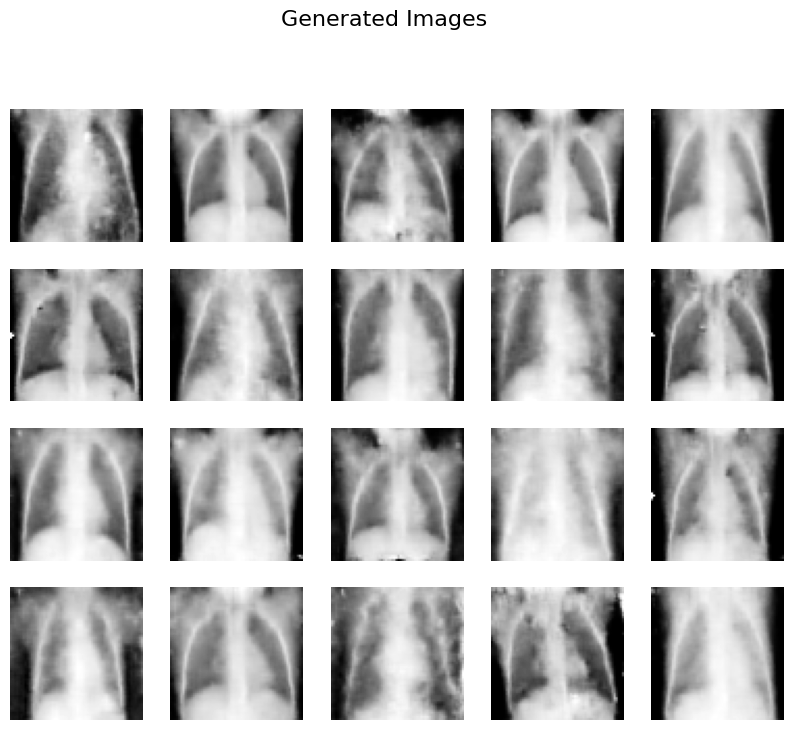

938/938 [==============================] - 5s 5ms/step
FID Score: 24.255172807788604
KID Score: 0.17157569005043483


In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_images(images, num_images=20, image_size=(64, 64), title="Generated Images"):
    # Calculate the grid size
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    # Create the plot
    plt.figure(figsize=(grid_size * 2, grid_size * 2))
    
    for i in range(num_images):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    
    if title:
        plt.suptitle(title, fontsize=16)
    
    plt.show()

# Generate synthetic images on CPU
with tf.device('/CPU:0'):  # Ensure operations run on the CPU
    latent_vectors = np.random.normal(size=(30000, latent_dim))  # Generate random latent vectors
    newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size=(30000,)), num_classes=2)

    # Generate synthetic images using the decoder from the CVAE model on CPU
    generated_images = []
    batch_size = 1000  # Adjust the batch size to prevent memory exhaustion
    for i in range(0, 30000, batch_size):
        latent_batch = latent_vectors[i:i+batch_size]
        label_batch = newlabels[i:i+batch_size]
        generated_images_batch = cvae.decode(latent_batch, label_batch, apply_sigmoid=True)
        generated_images.append(generated_images_batch)
    
    generated_images = np.concatenate(generated_images, axis=0)

plot_images(generated_images)

# Convert grayscale images to RGB
real_images_rgb = convert_grayscale_to_rgb(images)
generated_images_rgb = convert_grayscale_to_rgb(generated_images)

# Calculate FID and KID scores
fid_score = calculate_fid(real_images_rgb, generated_images_rgb)
kid_score = calculate_kid(real_images_rgb, generated_images_rgb)

print(f'FID Score: {fid_score}')
print(f'KID Score: {kid_score}')


In [9]:
# Convert TensorFlow tensors to NumPy arrays if necessary
#generated_images = generated_images.numpy()
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 1),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00002))
m.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [10]:
history = m.fit(generated_images, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
375/375 [==============================] - 21s 34ms/step - loss: 0.3754 - val_loss: 0.5688
Epoch 2/60
375/375 [==============================] - 11s 30ms/step - loss: 0.0898 - val_loss: 0.1065
Epoch 3/60
375/375 [==============================] - 11s 30ms/step - loss: 0.0654 - val_loss: 0.0483
Epoch 4/60
375/375 [==============================] - 11s 31ms/step - loss: 0.0551 - val_loss: 0.0548
Epoch 5/60
375/375 [==============================] - 12s 31ms/step - loss: 0.0445 - val_loss: 0.0429
Epoch 6/60
375/375 [==============================] - 12s 31ms/step - loss: 0.0398 - val_loss: 0.0249
Epoch 7/60
375/375 [==============================] - 12s 31ms/step - loss: 0.0353 - val_loss: 0.0175
Epoch 8/60
375/375 [==============================] - 11s 30ms/step - loss: 0.0306 - val_loss: 0.1056
Epoch 9/60
375/375 [==============================] - 11s 31ms/step - loss: 0.0305 - val_loss: 0.0348
Epoch 10/60
375/375 [==============================] - 12s 31ms/step - loss: 0.024

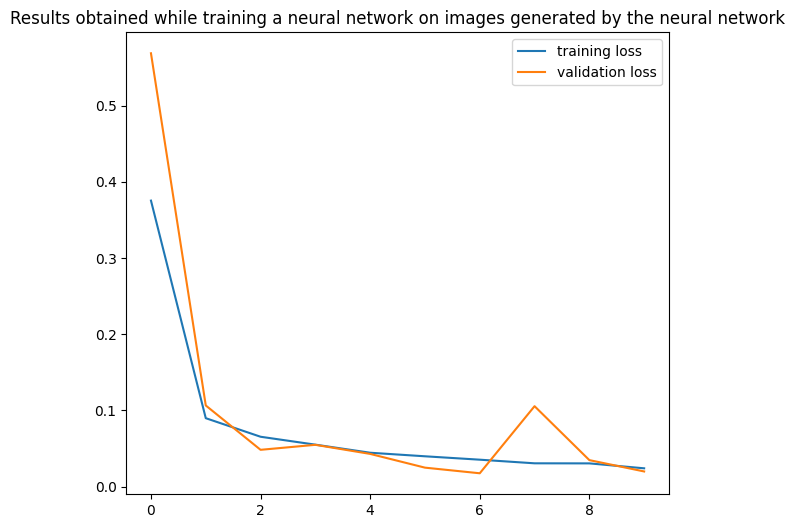

In [11]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [12]:
labels = np.argmax(labels, axis=1)  # Convert one-hot to binary labels (0 or 1)

In [13]:
images.shape,labels.shape

((5216, 64, 64, 1), (5216,))

In [14]:
m.evaluate(images, labels)

163/163 [==============================] - 1s 8ms/step - loss: 0.4432


0.44320735335350037

In [15]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 1s 6ms/step


TensorShape([5216])

In [16]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [17]:
accuracy_score(y_pred, labels)*100

86.56058282208589

In [18]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       1.00      0.66      0.79      2032
           1       0.82      1.00      0.90      3184

    accuracy                           0.87      5216
   macro avg       0.91      0.83      0.85      5216
weighted avg       0.89      0.87      0.86      5216



In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1336,  696],
       [   5, 3179]])

In [20]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

,NORMAL,PNEUMONIA
NORMAL,1336,696
PNEUMONIA,5,3179


In [21]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 90.06941493129338, recall_score: 99.8429648241206, precision_score: 82.03870967741935


<Axes: >

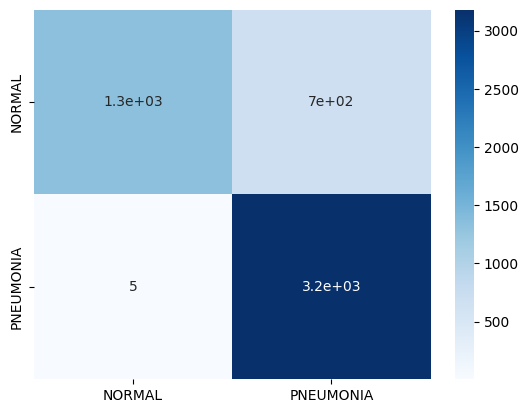

In [22]:
sns.heatmap(cmObject, annot = True, cmap="Blues")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os

def generate_new_images_from_cvae(cvae, latent_dim=16, num_classes=2, n_samples=9, frames_per_gif=100, gif_name="cvae_sampling.gif"):
    """Generate a GIF showing progressive image generation using a CVAE decoder, starting from pure noise."""
    # Create a directory for storing frames if it doesn't exist
    if not os.path.exists("frames"):
        os.makedirs("frames")
    
    # Step 1: Generate random latent vectors from a normal distribution
    z = np.random.normal(size=(n_samples, latent_dim))  # Final latent space vectors
    labels = np.zeros((n_samples, num_classes))  # Class labels (one-hot encoded)
    labels[:, 0] = 1  # Assuming all belong to class 0 (adjust if needed)

    # Generate initial random noise images (same shape as the final image output)
    noise_images = np.random.rand(n_samples, 64, 64, 1)  # Random noise images

    # Initialize the list to store frames for the GIF
    frames = []
    
    # Step 2: Interpolation and frame capture
    for frame_idx, alpha in enumerate(np.linspace(0, 1, frames_per_gif)):
        # Interpolation factor alpha: from 0 (pure noise) to 1 (final generation)
        step_z = z * alpha  # Interpolate latent vectors

        # Step 3: Generate images from the interpolated latent vectors using CVAE's decoder
        generated_images = cvae.decode(step_z, labels, apply_sigmoid=True).numpy()

        # Step 4: Interpolate between random noise and generated images
        blended_images = (1 - alpha) * noise_images + alpha * generated_images

        # Step 5: Normalize and reshape images for visualization
        normalized_images = (blended_images - np.min(blended_images)) / (np.max(blended_images) - np.min(blended_images)) * 255
        normalized_images = normalized_images.astype(np.uint8)  # Convert to uint8 format

        # Step 6: Create a 3x3 grid of the generated images
        fig, axes = plt.subplots(3, 3, figsize=(6, 6))
        for i, ax in enumerate(axes.flat):
            ax.imshow(normalized_images[i, :, :, 0], cmap='gray')
            ax.axis('off')  # Hide axes for a clean visualization

        # Adjust subplot layout and remove spaces between subplots
        plt.subplots_adjust(wspace=0, hspace=0)

        # Save the frame
        frame_filename = f'frames/frame_{frame_idx}.png'
        plt.savefig(frame_filename, bbox_inches='tight', pad_inches=0)
        plt.close(fig)  # Close the figure to free memory
        frames.append(frame_filename)

    # Step 7: Convert the frames into a GIF
    images = []
    for frame in frames:
        images.append(imageio.imread(frame))  # Read each frame
    imageio.mimsave(gif_name, images, duration=0.5)  # Save GIF with frame duration of 0.5 seconds
    
    # Cleanup: Remove temporary frame files
    for frame in frames:
        os.remove(frame)
    os.rmdir("frames")

    print(f"GIF saved as {gif_name}")


# Generate GIF from the CVAE decoder
generate_new_images_from_cvae(cvae, latent_dim=latent_dim, num_classes=num_classes, n_samples=9, frames_per_gif=100, gif_name='cvae_generation_from_noise.gif')
